# Applying for a Loan

## Goal

Another area where data science and machine learning play a huge role is in choosing if granting a loan. This is a particularly hot field as many start-ups feel that bank loan models can be improved. Therefore, there is space to come up with better loaning strategies that can benefit both the lender and the borrower.

In this challenge, you will have access to loan data from a bank and will have to improve their model.


## Challenge Description

We have access to a specific bank loan data. We have data about all loans asked to the bank, whether the bank decided to grant it and, finally, whether the borrower managed to repay it. We also have info about the person asking for the loan at the moment she is asking for the loan.

You have to come up with a better strategy to grant loans. Specifically you should:

- Build a model which is better than the bank model. Assume that:

If you grant the loan and the it doesn’t get repaid, you lose 1.

If you grant the loan and the it does get repaid, you gain 1

If you don’t grant the loan, you gain 0.

- Using the rules above, compare bank profitability vs your model profitability.


- Describe the impact of the most important variables on the prediction. Also, focus on the variable “is_employed”, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why.


- Are there any other variables you’d like to include in the model?


In [1]:
ls

12_Applying_for_a_loan.ipynb  loan_table.csv
borrower_table.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


In [3]:
df_loan = pd.read_csv('loan_table.csv')

print(df_loan.shape)
df_loan.head(10)

(101100, 5)


,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0
5,77085,other,2012-08-31,0,NaN
6,780070,business,2012-03-14,1,1.0
7,303138,emergency_funds,2012-08-31,1,0.0
8,91475,investment,2012-05-25,1,1.0
9,422392,business,2012-10-25,0,NaN


- loan_id : the id of the loan. Unique by loan. Can be joined to loan id in the other table
- loan_purpose : the reason for asking the loan: investment, other, business, emergency_funds, home
- date : when the loan was asked
- loan_granted : whether the loan was granted
- loan_repaid : whether the loan was repaid. NA means that the loan was not granted

In [4]:
df_borrow = pd.read_csv('borrower_table.csv')

print(df_borrow.shape)
df_borrow.head(10)

(101100, 12)


,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1
5,423171,1,NaN,NaN,6100,0.53,6163,5298,1,29500,24,1
6,568977,1,NaN,NaN,600,0.89,305,1456,0,0,50,2
7,200139,1,NaN,NaN,4000,0.57,602,2757,1,31700,36,8
8,991294,0,1.0,0.0,7000,0.52,2575,2917,1,58900,33,3
9,875332,0,1.0,0.0,4300,0.83,722,892,1,5400,32,7


- loan_id : the id of the the loan. Unique by loan. Can be joined to loan id in the other table
- is_first_loan : did she ask for any other loans in her lifetime?
- fully_repaid_previous_loans : did she pay on time all of her previous loans? If this is the first loan, it is NA
- currently_repaying_other_loans : is she currently repaying any other loans? If this is the first loan, it is NA
- total_credit_card_limit : total credit card monthly limit
- avg_percentage_credit_card_limit_used_last_year : on an average, how much did she use of her credit card limit in the previous 12 months. This number can be >1 since it is possible to go above the credit card limit
- saving_amount : total saving amount balance when she asked for the loan
- checking_amount : total checking amount balance when she asked for the loan
- is_employed : whether she is employed (1) or not (0)
- yearly_salary : how much she earned in the previous year
- age : her age
- dependent_number : number of people she claims as dependent

In [5]:
df_loan.dtypes

loan_id           int64
loan_purpose     object
date             object
loan_granted      int64
loan_repaid     float64
dtype: object

In [6]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
loan_id         101100 non-null int64
loan_purpose    101100 non-null object
date            101100 non-null object
loan_granted    101100 non-null int64
loan_repaid     47654 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


## Question I

Using the rules above, compare bank profitability vs your model profitability.

In [7]:
df_test = df_loan[['loan_granted','loan_repaid']][df_loan.loan_repaid.notnull()]
df_test.head()

,loan_granted,loan_repaid
3,1,1.0
4,1,0.0
6,1,1.0
7,1,0.0
8,1,1.0


In [8]:
df_test.loan_granted.value_counts()

1    47654
Name: loan_granted, dtype: int64

In [9]:
df_test.loan_repaid.value_counts()

1.0    30706
0.0    16948
Name: loan_repaid, dtype: int64

In [10]:
len(df_test[df_test.loan_repaid == 1]) - len(df_test[df_test.loan_repaid == 0])

13758

In [11]:
df = pd.merge(df_loan, df_borrow, how = 'left', on = 'loan_id')
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [12]:
df.loan_purpose.unique()

array(['investment', 'other', 'business', 'emergency_funds', 'home'],
      dtype=object)

### Group by Loan Purpose

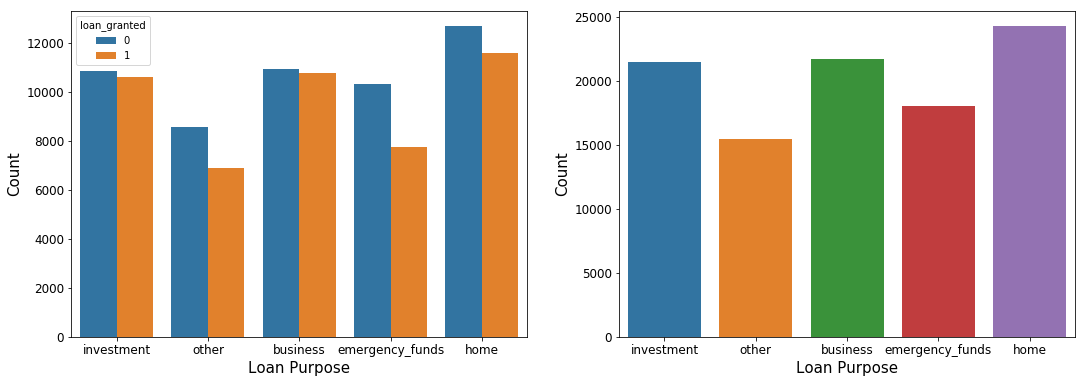

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='loan_purpose', hue='loan_granted', data=df, ax = ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=12)
#ax[0].set_xticklabels(labels, rotation=0, ha='right')

sns.countplot(x='loan_purpose', data=df, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [14]:
df[df.loan_granted == 1].loan_repaid.isnull().sum()

0

      loan_purpose  loan_repaid
0         business     0.722454
1  emergency_funds     0.489359
2             home     0.665232
3       investment     0.715929
4            other     0.551584


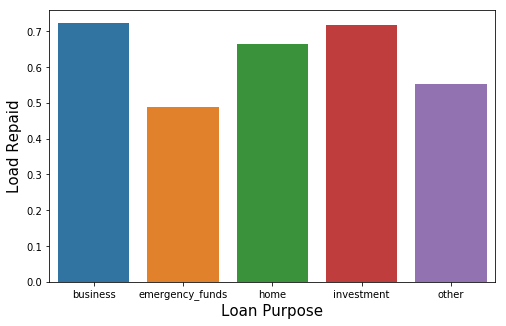

In [15]:
df_purpose = df[df.loan_granted == 1].groupby('loan_purpose')['loan_repaid'].mean().reset_index()
print(df_purpose)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='loan_purpose', y = 'loan_repaid', data=df_purpose, ax=ax)
ax.set_xlabel('Loan Purpose', fontsize=15)
ax.set_ylabel('Load Repaid', fontsize=15)
plt.show()

### Is First Loan

0


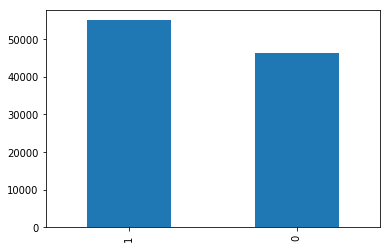

In [16]:
print(df.is_first_loan.isnull().sum())
df.is_first_loan.value_counts().plot.bar()

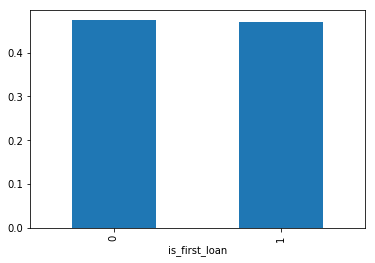

In [17]:
#sns.countplot(x='is_first_loan', data=df)
df.groupby('is_first_loan')['loan_granted'].mean().plot.bar()

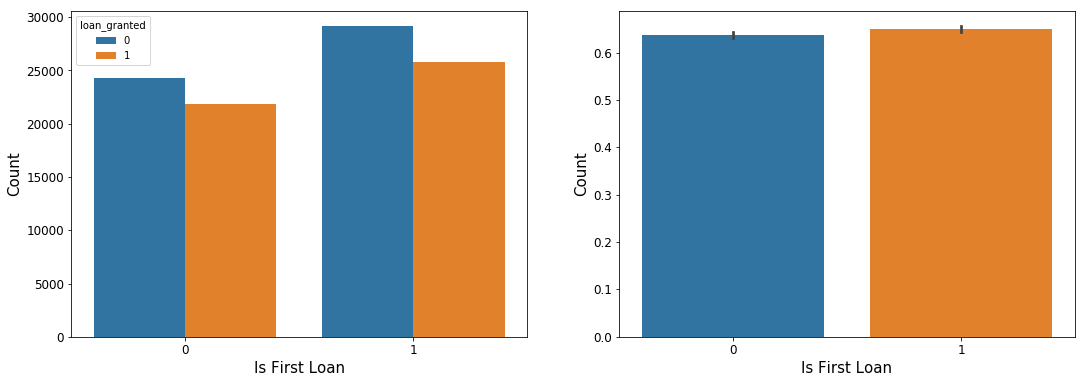

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='is_first_loan', hue='loan_granted', data=df, ax = ax[0])
ax[0].set_xlabel('Is First Loan', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=12)
#ax[0].set_xticklabels(labels, rotation=0, ha='right')

#sns.countplot(x='is_first_loan', hue='loan_repaid', data=df, ax=ax[1])
sns.barplot(x='is_first_loan', y='loan_repaid', data=df, ax=ax[1])
ax[1].set_xlabel('Is First Loan', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
plt.show()

### date

In [19]:
df.date = pd.to_datetime(df.date)
df.dtypes

loan_id                                                     int64
loan_purpose                                               object
date                                               datetime64[ns]
loan_granted                                                int64
loan_repaid                                               float64
is_first_loan                                               int64
fully_repaid_previous_loans                               float64
currently_repaying_other_loans                            float64
total_credit_card_limit                                     int64
avg_percentage_credit_card_limit_used_last_year           float64
saving_amount                                               int64
checking_amount                                             int64
is_employed                                                 int64
yearly_salary                                               int64
age                                                         int64
dependent_

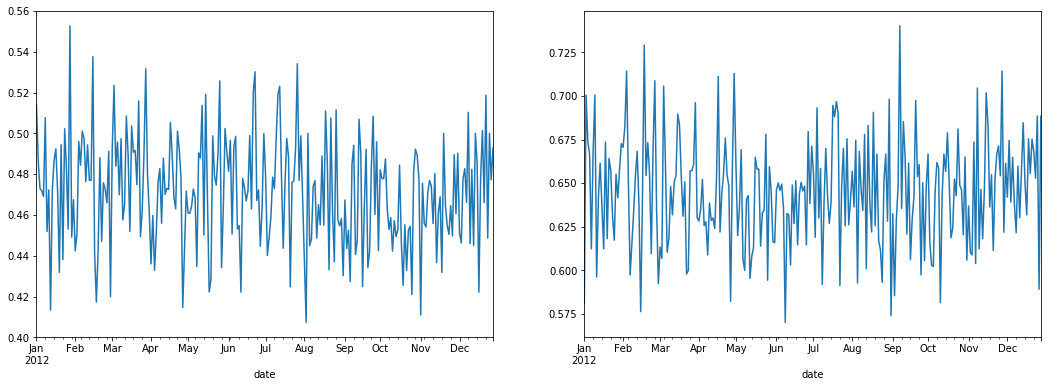

In [20]:
#sns.countplot(x = df.date, hue = df.loan_granted, data=df)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

df.groupby('date')['loan_granted'].mean().plot(ax=ax[0])
df.groupby('date')['loan_repaid'].mean().plot(ax=ax[1])

### fully_repaid_previous_loans

In [21]:
print(df.fully_repaid_previous_loans.isnull().sum())
df.fully_repaid_previous_loans.value_counts()

54947


1.0    41505
0.0     4648
Name: fully_repaid_previous_loans, dtype: int64

In [22]:
df.groupby('fully_repaid_previous_loans')['loan_granted'].mean()

fully_repaid_previous_loans
0.0    0.458692
1.0    0.475437
Name: loan_granted, dtype: float64

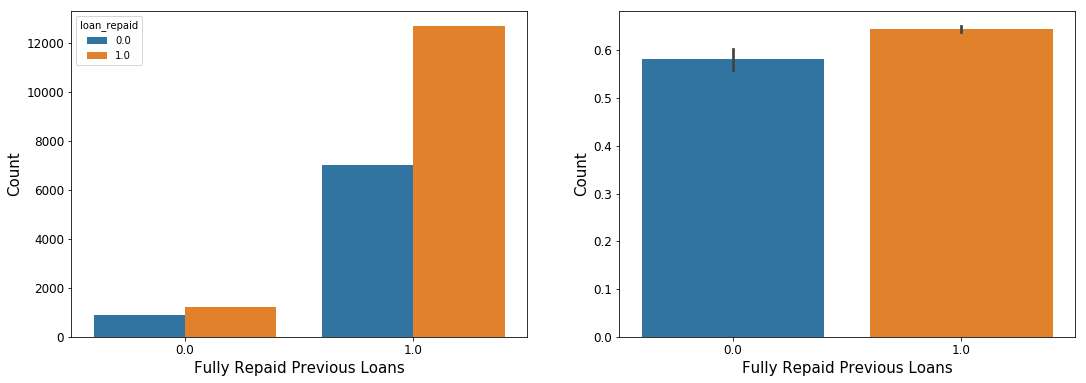

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='fully_repaid_previous_loans', hue='loan_repaid', data=df, ax = ax[0])
ax[0].set_xlabel('Fully Repaid Previous Loans', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=12)
#ax[0].set_xticklabels(labels, rotation=0, ha='right')

#sns.countplot(x='is_first_loan', hue='loan_repaid', data=df, ax=ax[1])
sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=df, ax=ax[1])
ax[1].set_xlabel('Fully Repaid Previous Loans', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
plt.show()

### currently_repaying_other_loans

In [24]:
print(df.currently_repaying_other_loans.isnull().sum())
df.currently_repaying_other_loans.value_counts()

54947


0.0    29338
1.0    16815
Name: currently_repaying_other_loans, dtype: int64

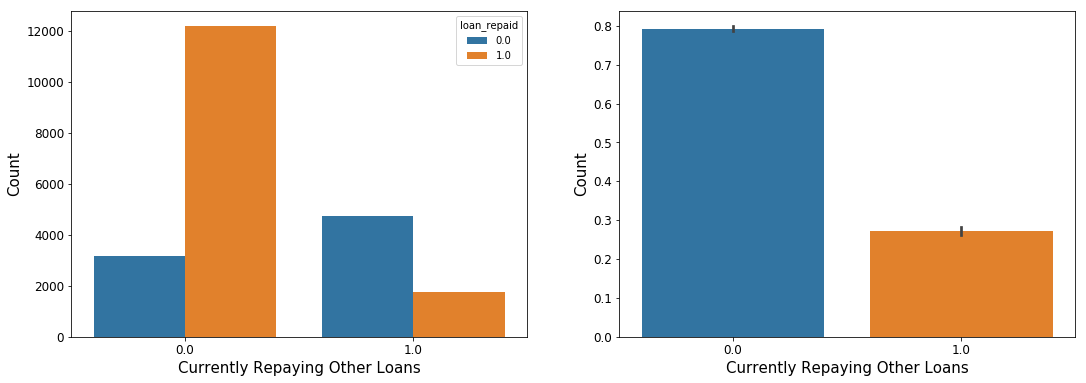

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='currently_repaying_other_loans', hue='loan_repaid', data=df, ax = ax[0])
ax[0].set_xlabel('Currently Repaying Other Loans', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=12)
#ax[0].set_xticklabels(labels, rotation=0, ha='right')

#sns.countplot(x='is_first_loan', hue='loan_repaid', data=df, ax=ax[1])
sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=df, ax=ax[1])
ax[1].set_xlabel('Currently Repaying Other Loans', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Total Credit Card Limit

In [26]:
df.total_credit_card_limit.isnull().sum()

0

In [27]:
df.total_credit_card_limit.unique()

array([ 8600,  5300,     0,  5400,  2900,  3000,  7800,  4300,  3900,
        1000,  6800,  4700,  2800,  5100,  6100,  2000,  3800,  3200,
        5200,  5800,  4600, 10100,  7500,  4100,  1300,  4500,  3300,
        3600,  6900,   800,  4800,  5900,  5700,  6000,  3400,  5600,
        2300,  5500,  3100,  6700,  3500,  4400,  7400,  4000,  2600,
        1700,  2100,  1800,  5000,  3700,  2400,  6300,  1500,  7200,
        1100,  7100,  4200,  9400,  2700,  6600,  2500,  9700,  6500,
        8300,  6400,  2200,  1600,  7000,  4900,  8200,   700,  7600,
        8000,   600,  8800,   900,  8500,  9000,  8400,  7300,  8100,
        6200,  9300,   500,  9200,  1900,  8700,  9500, 10000,  1400,
        7700,  1200,  7900, 11900, 10800,  8900, 10200, 10400,  9100,
       11600, 10500, 11000,  9600, 11400,  9900, 10300, 11700,  9800,
       10600, 10700, 11200, 10900, 12100, 13200, 11300, 11500, 11100,
       11800, 13500, 12400, 12000, 12700, 12200, 13300, 12500])

In [28]:
bins_number = [0, 2000, 3000,4000,5000,6000,8000,float('inf')]
bins = pd.cut(df.total_credit_card_limit,bins_number)
df_cc = df.groupby(bins)['loan_granted'].mean().reset_index(name='loan_ratio')
df_cc1 = df.groupby(bins)['loan_granted'].size().reset_index(name='counts')
df_cc = pd.merge(df_cc,df_cc1, how='left',on='total_credit_card_limit')
df_cc

,total_credit_card_limit,loan_ratio,counts
0,"(0.0, 2000.0]",0.400812,8126
1,"(2000.0, 3000.0]",0.445647,16163
2,"(3000.0, 4000.0]",0.469974,18767
3,"(4000.0, 5000.0]",0.506851,18173
4,"(5000.0, 6000.0]",0.535751,14475
5,"(6000.0, 8000.0]",0.562508,14926
6,"(8000.0, inf]",0.602916,3498


In [29]:
df_cc2 = df.groupby(bins)['loan_repaid'].mean().reset_index(name='repaid_ratio')
#df_cc3 = df.groupby(bins)['loan_repaid'].size().reset_index(name='counts')
df_cc = pd.merge(df_cc,df_cc2, how='left',on='total_credit_card_limit')
df_cc

,total_credit_card_limit,loan_ratio,counts,repaid_ratio
0,"(0.0, 2000.0]",0.400812,8126,0.277863
1,"(2000.0, 3000.0]",0.445647,16163,0.436207
2,"(3000.0, 4000.0]",0.469974,18767,0.563039
3,"(4000.0, 5000.0]",0.506851,18173,0.675062
4,"(5000.0, 6000.0]",0.535751,14475,0.773308
5,"(6000.0, 8000.0]",0.562508,14926,0.872320
6,"(8000.0, inf]",0.602916,3498,0.947368


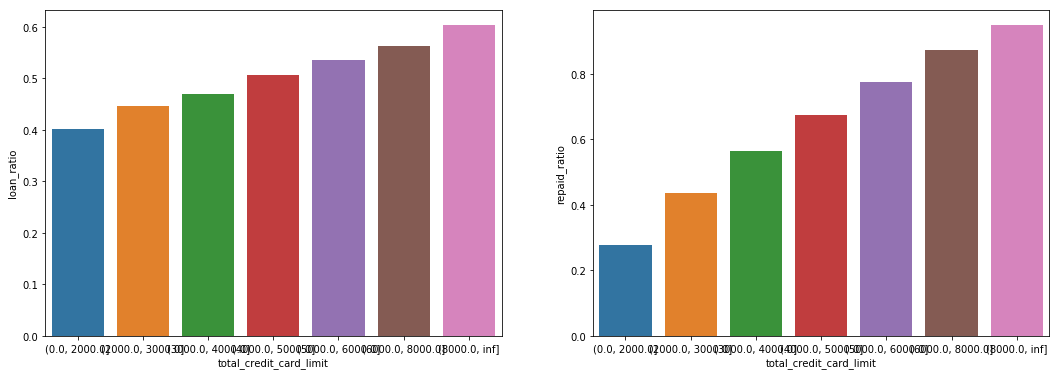

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x=df_cc.total_credit_card_limit, y = df_cc.loan_ratio, ax = ax[0])
sns.barplot(x=df_cc.total_credit_card_limit, y = df_cc.repaid_ratio, ax = ax[1])

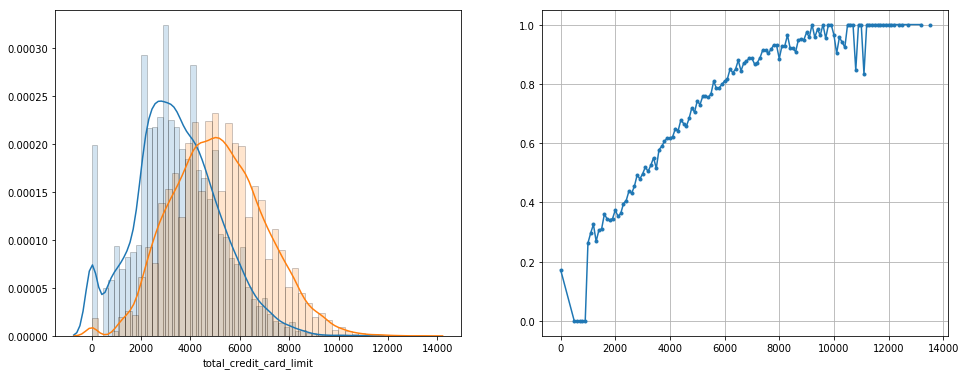

In [31]:
grouped = df[['total_credit_card_limit', 'loan_repaid']].groupby('total_credit_card_limit')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(df[df.loan_repaid==0].total_credit_card_limit, label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df[df.loan_repaid==1].total_credit_card_limit, label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['total_credit_card_limit'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

### avg_percentage_credit_card_limit_used_last_year

In [32]:
df.avg_percentage_credit_card_limit_used_last_year.isnull().sum()

6972

In [33]:
df.avg_percentage_credit_card_limit_used_last_year.unique()

array([0.79, 0.52,  nan, 0.76, 0.82, 0.3 , 1.02, 0.65, 1.09, 1.07, 0.89,
       0.83, 0.73, 0.42, 0.41, 0.98, 0.87, 0.38, 0.85, 0.59, 0.62, 0.96,
       0.68, 0.71, 0.77, 0.31, 0.8 , 1.  , 0.64, 0.67, 0.29, 0.74, 1.03,
       1.08, 0.99, 0.95, 0.94, 0.88, 0.61, 0.58, 0.7 , 0.69, 0.49, 0.6 ,
       0.97, 0.66, 0.47, 0.78, 0.55, 0.53, 0.48, 0.93, 0.46, 0.56, 0.51,
       0.23, 0.45, 0.72, 0.57, 0.75, 0.5 , 0.84, 0.92, 0.86, 0.81, 1.04,
       0.63, 0.9 , 0.27, 0.91, 1.05, 0.44, 0.22, 0.33, 0.4 , 1.01, 0.43,
       0.28, 0.54, 0.26, 0.34, 0.39, 0.37, 1.06, 0.19, 0.17, 0.18, 0.32,
       0.36, 0.21, 0.25, 0.35, 0.12, 0.1 , 0.24, 0.2 , 0.15, 0.16, 0.13,
       0.06, 0.07, 0.02, 0.05, 0.11, 0.03, 0.04, 0.09, 0.14, 0.08, 0.  ,
       0.01])

In [34]:
grouped = df[['avg_percentage_credit_card_limit_used_last_year', 'loan_repaid']]\
         .groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped.mean().reset_index()
mean

,avg_percentage_credit_card_limit_used_last_year,loan_repaid
0,0.00,1.000000
1,0.01,NaN
2,0.02,1.000000
3,0.03,0.000000
4,0.04,0.750000
5,0.05,1.000000
6,0.06,1.000000
7,0.07,0.800000
8,0.08,1.000000
9,0.09,0.875000


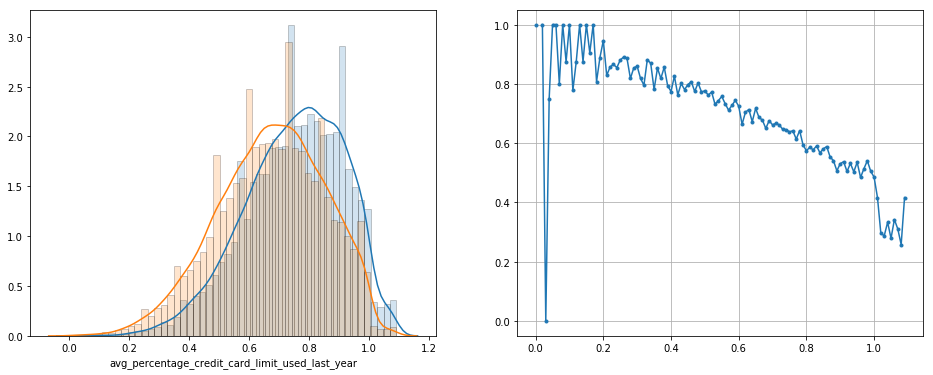

In [35]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

df_avg_percent = df[df.avg_percentage_credit_card_limit_used_last_year.notnull()]


sns.distplot(df_avg_percent[df_avg_percent.loan_repaid==0].avg_percentage_credit_card_limit_used_last_year, 
             label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df_avg_percent[df_avg_percent.loan_repaid==1].avg_percentage_credit_card_limit_used_last_year, 
             label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['avg_percentage_credit_card_limit_used_last_year'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

plt.show()

In [36]:
bins_number = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,float('inf')]
bins = pd.cut(df.avg_percentage_credit_card_limit_used_last_year,bins_number)
df_ave_percent = df.groupby(bins)['loan_repaid'].mean().reset_index(name='repaid_ratio')
df_ave_percent1 = df.groupby(bins)['loan_repaid'].size().reset_index(name='counts')
df_ave_percent = pd.merge(df_ave_percent,df_ave_percent1, how='left',
                          on='avg_percentage_credit_card_limit_used_last_year')
df_ave_percent

,avg_percentage_credit_card_limit_used_last_year,repaid_ratio,counts
0,"(0.0, 0.4]",0.837665,4898
1,"(0.4, 0.5]",0.789014,7168
2,"(0.5, 0.6]",0.739267,12442
3,"(0.6, 0.7]",0.682157,17362
4,"(0.7, 0.8]",0.633012,18880
5,"(0.8, 0.9]",0.563882,16435
6,"(0.9, 1.0]",0.515513,11162
7,"(1.0, inf]",0.326409,5779


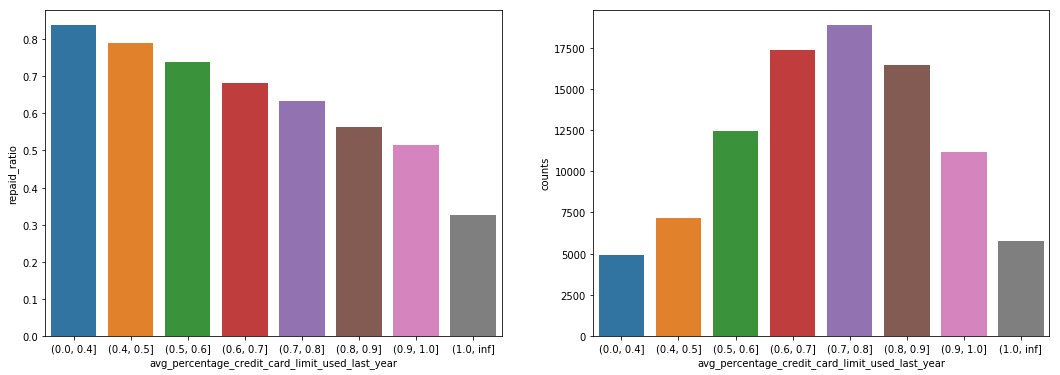

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x=df_ave_percent.avg_percentage_credit_card_limit_used_last_year, 
            y = df_ave_percent.repaid_ratio, ax = ax[0])
sns.barplot(x=df_ave_percent.avg_percentage_credit_card_limit_used_last_year, 
            y = df_ave_percent.counts, ax = ax[1])

plt.show()

### saving_amount

In [38]:
df.saving_amount.isnull().sum()

0

In [39]:
df.saving_amount.unique()

array([1491,  141,  660, ..., 6393, 6257, 5711])

In [40]:
bins_number = [0, 500, 1000, 1500, 2000, 3000, 4000,float('inf')]
bins = pd.cut(df.saving_amount,bins_number)
df_saving = df.groupby(bins)['loan_repaid'].mean().reset_index(name='repaid_ratio')
df_saving2 = df.groupby(bins)['loan_repaid'].size().reset_index(name='counts')
df_saving = pd.merge(df_saving, df_saving2, how = 'left', on = 'saving_amount')
df_saving

,saving_amount,repaid_ratio,counts
0,"(0.0, 500.0]",0.503161,11044
1,"(500.0, 1000.0]",0.342280,22564
2,"(1000.0, 1500.0]",0.365188,23365
3,"(1500.0, 2000.0]",0.601689,12988
4,"(2000.0, 3000.0]",0.949684,12713
5,"(3000.0, 4000.0]",1.000000,8962
6,"(4000.0, inf]",1.000000,9456


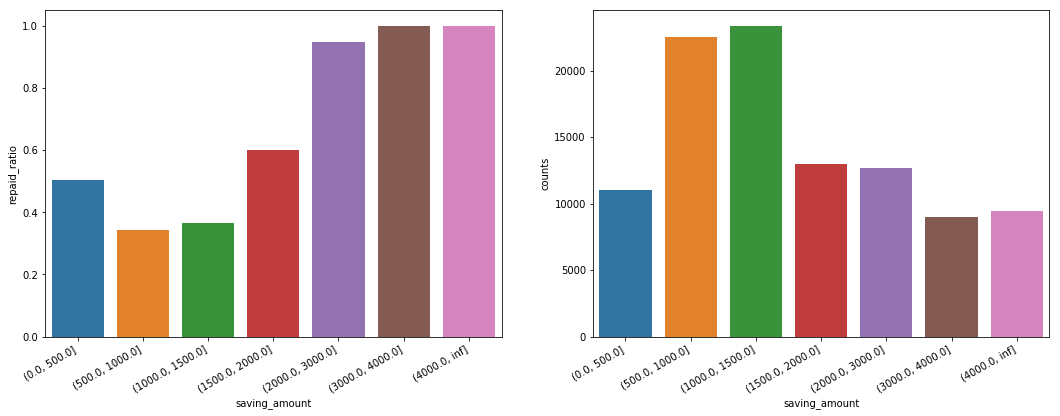

In [41]:
labels = list(df_saving.saving_amount.unique())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x=df_saving.saving_amount, y = df_saving.repaid_ratio, ax = ax[0])
ax[0].set_xticklabels(labels, rotation=30, ha='right')

sns.barplot(x=df_saving.saving_amount, y = df_saving.counts, ax = ax[1])
ax[1].set_xticklabels(labels, rotation=30, ha='right')
plt.show()

In [42]:
grouped = df[['saving_amount', 'loan_repaid']].groupby('saving_amount')
mean = grouped.mean().reset_index()

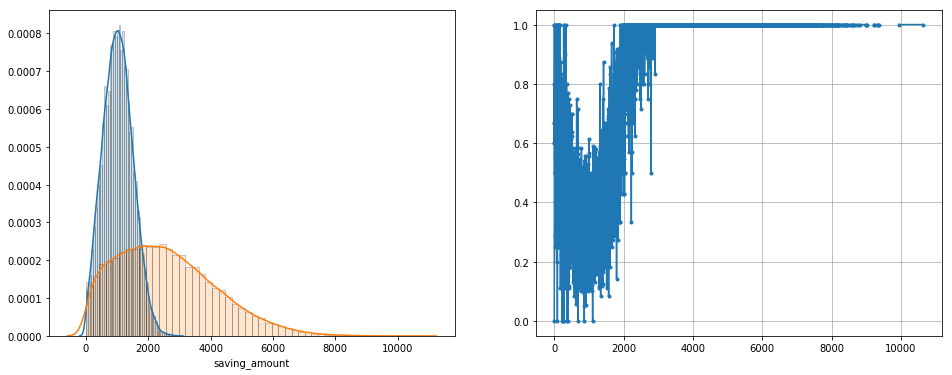

In [43]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(df[df.loan_repaid==0].saving_amount, 
             label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df[df.loan_repaid==1].saving_amount, 
             label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['saving_amount'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

plt.show()

### checking_amount

In [44]:
df.checking_amount.isnull().sum()

0

In [45]:
grouped = df[['checking_amount', 'loan_repaid']].groupby('checking_amount')
mean = grouped.mean().reset_index()

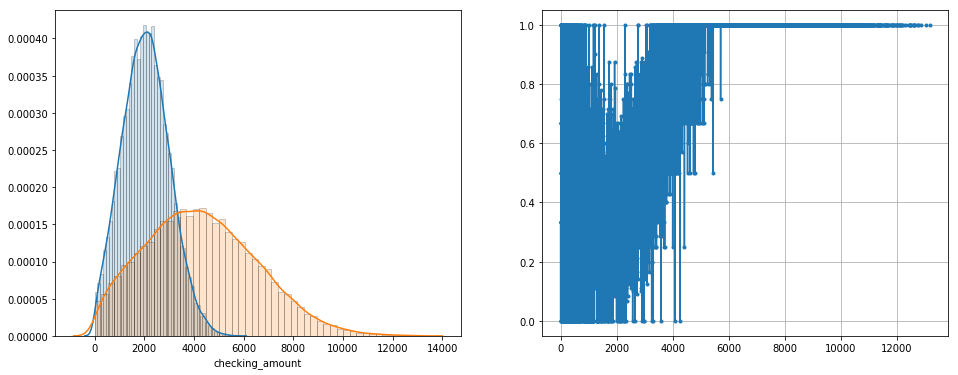

In [46]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(df[df.loan_repaid==0].checking_amount, 
             label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df[df.loan_repaid==1].checking_amount, 
             label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['checking_amount'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

plt.show()

### Is Employed

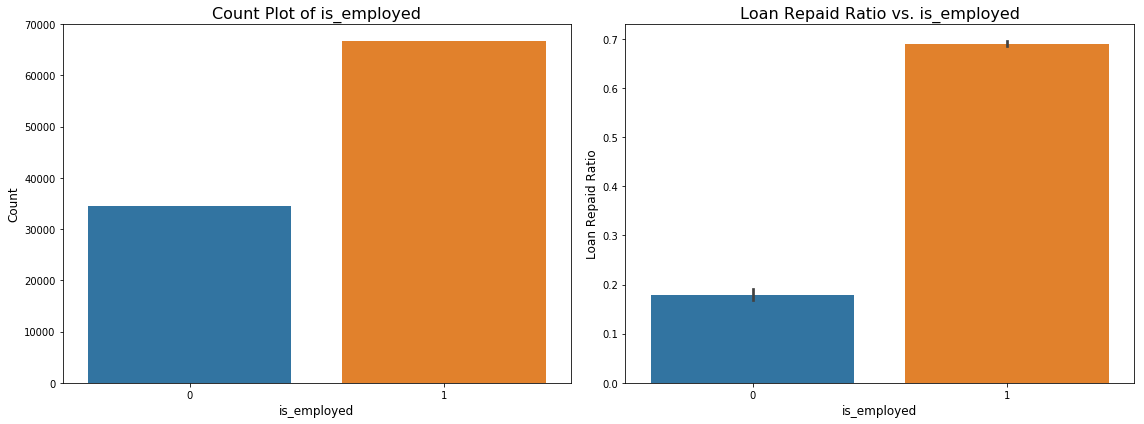

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_employed', data=df, ax=ax[0])
ax[0].set_xlabel('is_employed', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='is_employed', y='loan_repaid', data=df, ax=ax[1])
ax[1].set_xlabel('is_employed', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_employed', fontsize=16)
plt.tight_layout()
plt.show()

### yearly_salary

In [48]:
df.yearly_salary.isnull().sum()

0

In [49]:
df_salary = df[df.yearly_salary > 0]

In [50]:
grouped = df_salary[['yearly_salary', 'loan_repaid']].groupby('yearly_salary')
mean = grouped.mean().reset_index()

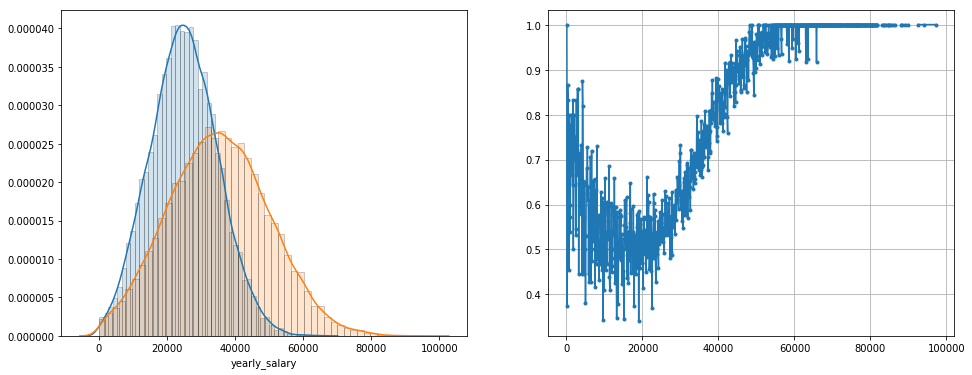

In [51]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(df_salary[df_salary.loan_repaid==0].yearly_salary, 
             label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df_salary[df_salary.loan_repaid==1].yearly_salary, 
             label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['yearly_salary'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

plt.show()

### age

In [52]:
df.age.isnull().sum()

0

In [53]:
grouped = df[['age', 'loan_repaid']].groupby('age')
mean = grouped.mean().reset_index()

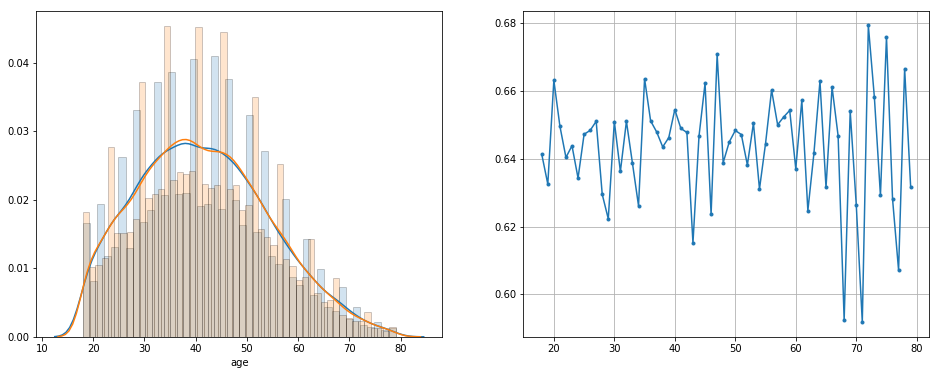

In [54]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(df[df.loan_repaid==0].age, label='loan_repaid = 0', hist_kws=hist_kws, ax=ax[0])
sns.distplot(df[df.loan_repaid==1].age, label='loan_repaid = 1', hist_kws=hist_kws, ax=ax[0])

ax[1].plot(mean['age'], mean['loan_repaid'], '.-')
ax[1].grid(True)
plt.show()

plt.show()

### dependent_number

In [55]:
df.dependent_number.isnull().sum()

0

In [56]:
df.dependent_number.value_counts()

1    20050
8    19818
2    18153
3    13150
4     9730
5     7257
6     5399
7     4111
0     3432
Name: dependent_number, dtype: int64

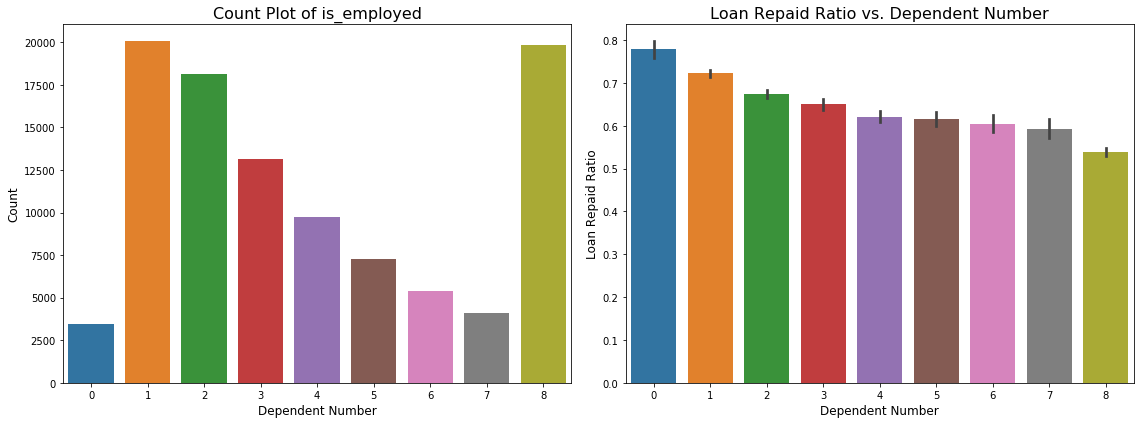

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dependent_number', data=df, ax=ax[0])
ax[0].set_xlabel('Dependent Number', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='dependent_number', y='loan_repaid', data=df, ax=ax[1])
ax[1].set_xlabel('Dependent Number', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Dependent Number', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Engineering

In [58]:
# Again, check missing values

df.isnull().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [59]:
df2 = df[df.loan_repaid.notnull()]

df2.isnull().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                            0
is_first_loan                                          0
fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year      903
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [60]:
df2.loan_repaid.value_counts()

1.0    30706
0.0    16948
Name: loan_repaid, dtype: int64

In [61]:
df2.fully_repaid_previous_loans = df2.fully_repaid_previous_loans.fillna(-1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [62]:
df2.currently_repaying_other_loans = df2.currently_repaying_other_loans.fillna(-1)

In [63]:
median_temp = df2.avg_percentage_credit_card_limit_used_last_year.median()
df2.avg_percentage_credit_card_limit_used_last_year = \
df2.avg_percentage_credit_card_limit_used_last_year.fillna(median_temp)

In [64]:
df2.isnull().sum()

loan_id                                            0
loan_purpose                                       0
date                                               0
loan_granted                                       0
loan_repaid                                        0
is_first_loan                                      0
fully_repaid_previous_loans                        0
currently_repaying_other_loans                     0
total_credit_card_limit                            0
avg_percentage_credit_card_limit_used_last_year    0
saving_amount                                      0
checking_amount                                    0
is_employed                                        0
yearly_salary                                      0
age                                                0
dependent_number                                   0
dtype: int64

In [65]:
# change loan_purpose to numbers

encoder = LabelEncoder()
df2['loan_purpose'] = encoder.fit_transform(df2['loan_purpose'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [66]:
df2 = df2.drop('date',axis=1)
df2.head()

,loan_id,loan_purpose,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,580653,4,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,0,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,780070,0,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,303138,1,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,91475,3,1,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


## Machine Learning

In [67]:
from sklearn.model_selection import train_test_split

X = df2.drop('loan_repaid', axis=1)
y = df2.loan_repaid

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)

In [69]:
y_test.value_counts()

1.0    7677
0.0    4237
Name: loan_repaid, dtype: int64

### Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import confusion_matrix

DT = DecisionTreeClassifier(class_weight="balanced", max_features=5, random_state=27)
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

importances1 = DT.feature_importances_
important_list1 = {}
for i in np.argsort(importances1)[::-1]:
    important_list1[X.columns[i]] = importances1[i]

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83      4237
         1.0       0.90      0.91      0.90      7677

    accuracy                           0.88     11914
   macro avg       0.87      0.86      0.87     11914
weighted avg       0.88      0.88      0.88     11914

[[3486  751]
 [ 713 6964]]


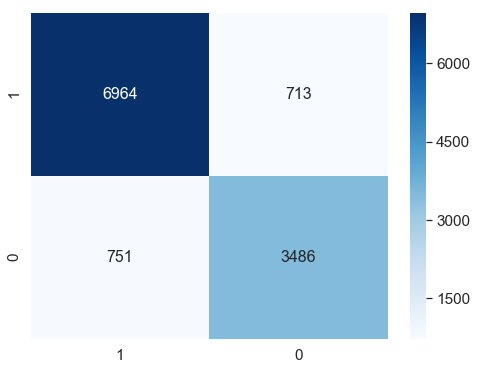

In [71]:
matrix = confusion_matrix(y_test,y_pred)[::-1,::-1]

df_cm = pd.DataFrame(matrix, range(2)[::-1], range(2)[::-1])
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

In [72]:
print(y_test.value_counts())
print(pd.Series(y_pred).value_counts())

1.0    7677
0.0    4237
Name: loan_repaid, dtype: int64
1.0    7715
0.0    4199
dtype: int64


In [73]:
#print("Score Test: ",len(y_test[y_test==1]) - len(y_test[y_test==0]))
#print("Pred Test: ",len(y_pred[y_pred==1]) - len(y_pred[y_pred==0]))

### Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced",n_estimators=100, max_features=5, random_state=27)
rf.fit(X_train,y_train)
y_pred =rf.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

importances2 = rf.feature_importances_
important_list2 = {}
for i in np.argsort(importances2)[::-1]:
    important_list2[X.columns[i]] = importances2[i]

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      4237
         1.0       0.94      0.93      0.93      7677

    accuracy                           0.92     11914
   macro avg       0.91      0.91      0.91     11914
weighted avg       0.92      0.92      0.92     11914

[[3816  421]
 [ 568 7109]]


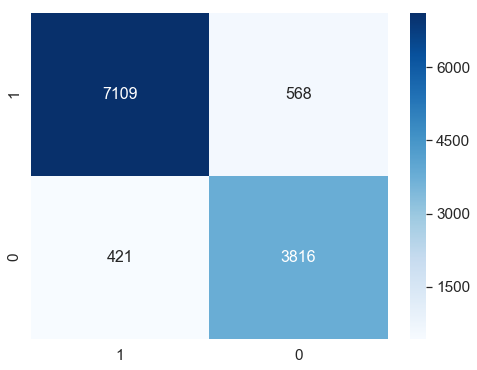

In [75]:
matrix = confusion_matrix(y_test,y_pred)[::-1,::-1]

df_cm = pd.DataFrame(matrix, range(2)[::-1], range(2)[::-1])
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

In [76]:
print(y_test.value_counts())
print(pd.Series(y_pred).value_counts())

#print("Score Test: ",len(y_test[y_test==1]) - len(y_test[y_test==0]))
#print("Pred Test: ",len(y_pred[y_pred==1]) - len(y_pred[y_pred==0]))

1.0    7677
0.0    4237
Name: loan_repaid, dtype: int64
1.0    7530
0.0    4384
dtype: int64


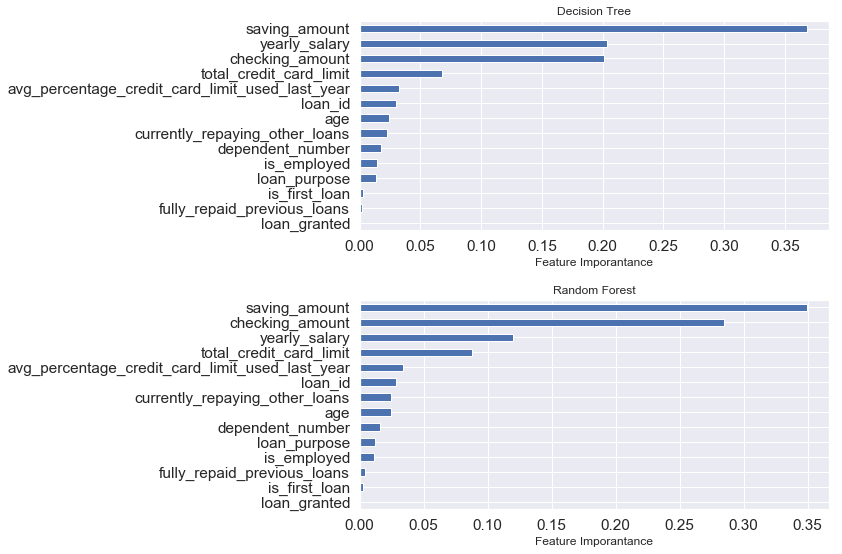

In [77]:
# check feature importance between decision tree and random forest. Very similiar. 

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
pd.Series(important_list1)[::-1].plot(kind='barh', ax=ax[0])
ax[0].set_title('Decision Tree', fontsize=12)
ax[0].set_xlabel('Feature Imporantance', fontsize=12)

pd.Series(important_list2)[::-1].plot(kind='barh', ax=ax[1])
ax[1].set_title('Random Forest', fontsize=12)
ax[1].set_xlabel('Feature Imporantance', fontsize=12)
plt.tight_layout()
plt.show()

### XGBoost

In [78]:
from xgboost.sklearn import XGBClassifier

# Fit XGBoost model, default parameters 

xgb = XGBClassifier(n_estimators=200, max_features=5, random_state=27)

xgb.fit(X_train,y_train)
y_pred =xgb.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

importances = rf.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      4237
         1.0       0.95      0.93      0.94      7677

    accuracy                           0.92     11914
   macro avg       0.91      0.92      0.91     11914
weighted avg       0.92      0.92      0.92     11914

[[3855  382]
 [ 558 7119]]


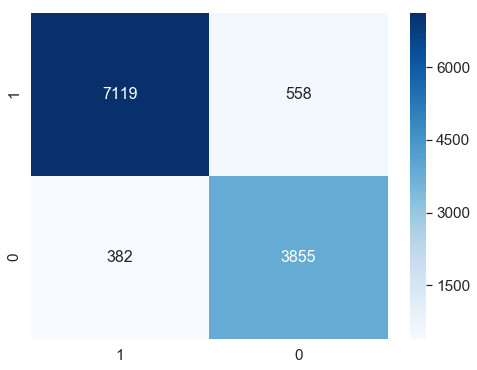

In [79]:
matrix = confusion_matrix(y_test,y_pred)[::-1,::-1]

df_cm = pd.DataFrame(matrix, range(2)[::-1], range(2)[::-1])
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

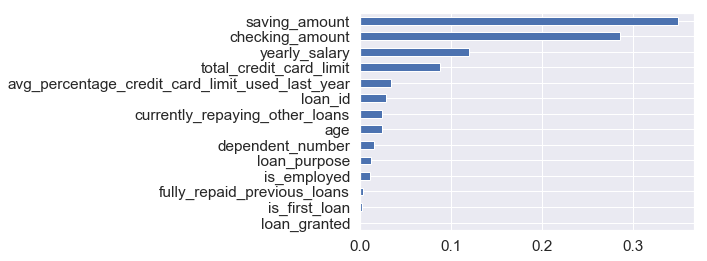

In [80]:
pd.Series(important_list)[::-1].plot(kind='barh')

In [81]:
print(y_test.value_counts())
print(pd.Series(y_pred).value_counts())

#print("Score Test: ",len(y_test[y_test==1]) - len(y_test[y_test==0]))
#print("Pred Test: ",len(y_pred[y_pred==1]) - len(y_pred[y_pred==0]))

1.0    7677
0.0    4237
Name: loan_repaid, dtype: int64
1.0    7501
0.0    4413
dtype: int64


In [82]:
# cross validation

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(class_weight="balanced",n_estimators=100, max_features=5, random_state=27)
y_pred_cv = cross_val_predict(rf, X, y, cv=10)
print(classification_report(y, y_pred_cv))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89     16948
         1.0       0.94      0.93      0.94     30706

    accuracy                           0.92     47654
   macro avg       0.91      0.91      0.91     47654
weighted avg       0.92      0.92      0.92     47654



## Question I

Using the rules above, compare bank profitability vs your model profitability.

Go back to the XGBoost model. I use the testing model for example. 

In [83]:
xgb.fit(X_train,y_train)
y_pred =xgb.predict(X_test)

In [84]:
y_test = y_test.reset_index()
y_test['bank'] = 1

In [85]:
y_test['my_model'] = y_pred
y_test

,index,loan_repaid,bank,my_model
0,14366,0.0,1,0.0
1,35926,1.0,1,1.0
2,64849,1.0,1,0.0
3,78487,1.0,1,1.0
4,59066,1.0,1,1.0
5,70549,1.0,1,0.0
6,91335,1.0,1,1.0
7,2237,1.0,1,1.0
8,83593,0.0,1,1.0
9,29985,1.0,1,1.0


In [86]:
# Bank Score:

len(y_test[y_test.loan_repaid == 1]) - len(y_test[y_test.loan_repaid == 0])

3440

In [87]:
# My model score:

len(y_test[(y_test.my_model == 1) & (y_test.loan_repaid == 1)]) \
  - len(y_test[(y_test.my_model == 1) & (y_test.loan_repaid == 0)])

6737

Much better than the bank score.

## Question II

Describe the impact of the most important variables on the prediction. Also, focus on the variable “is_employed”, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why.

I did EDA, and also select feature importance. The most important feature is saving_amount and checking_amount. 

For "is_employed", employed people have much higher repaid rate than unemployed people.


## Question III

Are there any other variables you’d like to include in the model?